<a href="https://colab.research.google.com/github/9berny9/cookie_cats_analysis/blob/main/cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAČTENÍ KNIHOVEN

In [12]:
import pandas as pd
from matplotlib import pyplot as plt

# READING DATA

In [75]:
url = 'https://raw.githubusercontent.com/9berny9/cookie_cats_analysis/main/cookie_cats.csv?token=GHSAT0AAAAAABTXMXCXNO4434XQSJR7QTR2YWG4M2Q'
df = pd.read_csv(url, encoding='unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Data neobsahují nulové hodnoty.

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


# Základní popisné statistiky

In [36]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

- data neobsahují nulové hodnoty (počet záznamů je shodný s počtem uživatelů)
- 25% uživatelů z našeho datasetu odehrálo 5 her během 14 dnů.
- 50% medián uživatelů z našeho datasetu odehrálo 16 her během 14 dnů.
- 75% uživatelů z našeho datasetu odehrálo 51 her během 14 dnů.
- minimální počet odehraných her je 0, takže uživatel pouze nainstaloval hru
- maximální počet odehraných her je 49854 a tento počet her se výrazně vychyluje od ostatních odehraných her
- směrodatná odchylka se výrazně liší od průměru, takže se v měření nachází odlehlá měření

# Kontrola dat

In [55]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

V datech se nenachází Null hodnoty

In [11]:
# check unique user id
df.userid.nunique()

90189

User ID je vždy unikátní.

In [40]:
df.version.nunique()

2

In [52]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

V datasetu se nachází pouze dvě verze módů, což odpovídá A/B testování a Gate 40 má více záznamů než Gate 30.


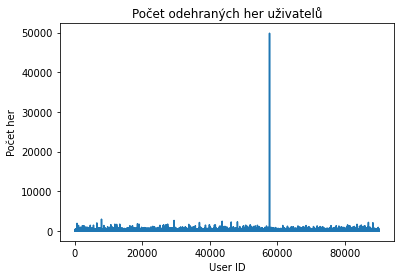

In [92]:
plt.title("Počet odehraných her uživatelů")
plt.xlabel("User ID")
plt.ylabel("Počet her")
plt.plot(df.sum_gamerounds);

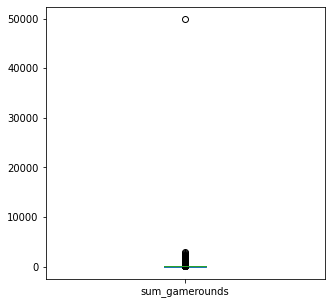

In [61]:
df.sum_gamerounds.plot.box(figsize=(5, 5));

Z boxplotu jsme si ověřili, že opravdu jedno měření je velmi odlehlé od ostatních měření a je potřeba tyto hodnoty odstranit.

In [82]:
df1 = df[df.sum_gamerounds < 10000]  

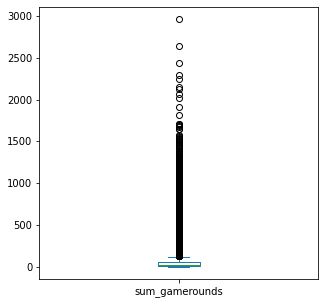

In [93]:
df1.sum_gamerounds.plot.box(figsize=(5, 5));

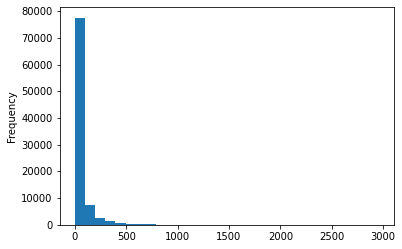

In [84]:

df1.sum_gamerounds.plot(kind="hist", bins=30);